In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 10097, done.
remote: Total 10097 (delta 0), reused 0 (delta 0), pack-reused 10097 (from 1)
Receiving objects: 100% (10097/10097), 1.92 GiB | 42.47 MiB/s, done.
Resolving deltas: 100% (1459/1459), done.
Updating files: 100% (8654/8654), done.


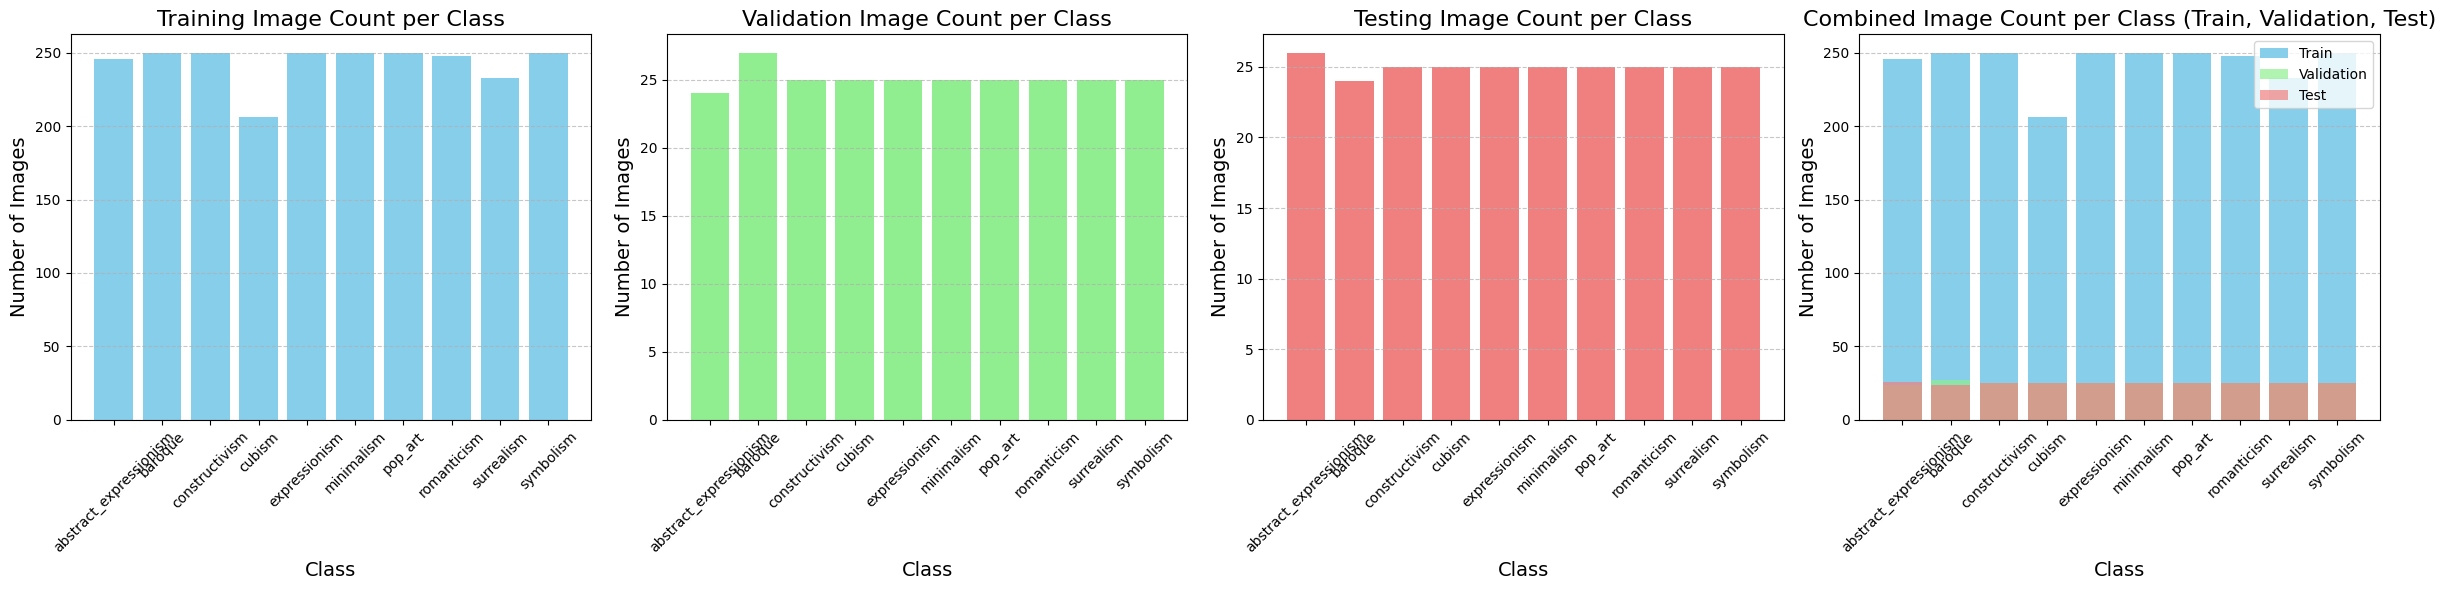

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/memorability_model/memorability_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch

# Mapping of art styles to 4 memorability classes (multi-label binary format)
class_to_main_class = {
    "pop_art": [1, 0, 0, 0],               # Iconic Imagery
    "surrealism": [1, 0, 1, 0],            # Iconic Imagery + Symbolism
    "expressionism": [1, 0, 0, 0],         # Iconic Imagery

    "cubism": [0, 1, 0, 0],                # Contrast and Juxtaposition
    "baroque": [0, 1, 0, 0],
    "abstract_expressionism": [0, 1, 0, 0],

    "symbolism": [0, 0, 1, 0],             # Symbolism and Visual Metaphor
    "romanticism": [0, 0, 1, 0],

    "minimalism": [0, 0, 0, 1],            # Simplicity and Minimalism
    "constructivism": [0, 0, 0, 1]
}

# Custom dataset class for memorability model
class CustomMemorabilityDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to dataset (change as needed)
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/memorability_model/memorability_dataset"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
train_data = CustomMemorabilityDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomMemorabilityDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomMemorabilityDataset(root_dir=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=1.77]


Epoch 1/25 completed in 37.21 seconds.
Epoch Loss: 1.5843
Train Accuracy: 81.94%


Validation Accuracy: 85.56%


Epoch 2/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.10batch/s, loss=2.81]


Epoch 2/25 completed in 36.74 seconds.
Epoch Loss: 0.7660
Train Accuracy: 93.13%


Validation Accuracy: 84.46%


Epoch 3/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=2.99]


Epoch 3/25 completed in 37.27 seconds.
Epoch Loss: 0.4021
Train Accuracy: 96.77%


Validation Accuracy: 88.45%


Epoch 4/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=5.39]


Epoch 4/25 completed in 37.13 seconds.
Epoch Loss: 0.3040
Train Accuracy: 97.99%


Validation Accuracy: 87.65%


Epoch 5/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=2.6]


Epoch 5/25 completed in 36.84 seconds.
Epoch Loss: 0.2534
Train Accuracy: 98.18%


Validation Accuracy: 86.75%


Epoch 6/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=1.12]


Epoch 6/25 completed in 36.90 seconds.
Epoch Loss: 0.2348
Train Accuracy: 98.11%


Validation Accuracy: 86.55%


Epoch 7/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=5.66]


Epoch 7/25 completed in 36.87 seconds.
Epoch Loss: 0.2248
Train Accuracy: 98.66%


Validation Accuracy: 86.55%


Epoch 8/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.10batch/s, loss=2.99]


Epoch 8/25 completed in 36.73 seconds.
Epoch Loss: 0.1986
Train Accuracy: 98.61%


Validation Accuracy: 86.25%


Epoch 9/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=3.97]


Epoch 9/25 completed in 36.90 seconds.
Epoch Loss: 0.1908
Train Accuracy: 98.90%


Validation Accuracy: 86.06%


Epoch 10/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.08batch/s, loss=5.84]


Epoch 10/25 completed in 36.96 seconds.
Epoch Loss: 0.1664
Train Accuracy: 99.29%


Validation Accuracy: 87.15%


Epoch 11/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.10batch/s, loss=1.97]


Epoch 11/25 completed in 36.71 seconds.
Epoch Loss: 0.1246
Train Accuracy: 99.24%


Validation Accuracy: 85.76%


Epoch 12/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=3.33]


Epoch 12/25 completed in 37.25 seconds.
Epoch Loss: 0.1697
Train Accuracy: 98.99%


Validation Accuracy: 82.87%


Epoch 13/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=3.1]


Epoch 13/25 completed in 36.84 seconds.
Epoch Loss: 0.1878
Train Accuracy: 98.72%


Validation Accuracy: 87.85%


Epoch 14/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=5.35]


Epoch 14/25 completed in 37.27 seconds.
Epoch Loss: 0.1899
Train Accuracy: 98.78%


Validation Accuracy: 88.05%


Epoch 15/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=5.27]


Epoch 15/25 completed in 37.02 seconds.
Epoch Loss: 0.1387
Train Accuracy: 99.52%


Validation Accuracy: 86.35%


Epoch 16/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=4.67]


Epoch 16/25 completed in 37.11 seconds.
Epoch Loss: 0.1292
Train Accuracy: 99.48%


Validation Accuracy: 87.05%


Epoch 17/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=5.86]


Epoch 17/25 completed in 36.86 seconds.
Epoch Loss: 0.1708
Train Accuracy: 99.19%


Validation Accuracy: 86.16%


Epoch 18/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.08batch/s, loss=3.91]


Epoch 18/25 completed in 36.99 seconds.
Epoch Loss: 0.1442
Train Accuracy: 99.26%


Validation Accuracy: 85.66%


Epoch 19/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=1.98]


Epoch 19/25 completed in 37.01 seconds.
Epoch Loss: 0.1221
Train Accuracy: 99.30%


Validation Accuracy: 87.05%


Epoch 20/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=1.38]


Epoch 20/25 completed in 37.18 seconds.
Epoch Loss: 0.0796
Train Accuracy: 99.50%


Validation Accuracy: 87.85%


Epoch 21/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.06batch/s, loss=4.09]


Epoch 21/25 completed in 37.42 seconds.
Epoch Loss: 0.1079
Train Accuracy: 99.51%


Validation Accuracy: 86.35%


Epoch 22/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=1.07]


Epoch 22/25 completed in 37.25 seconds.
Epoch Loss: 0.0615
Train Accuracy: 99.65%


Validation Accuracy: 86.16%


Epoch 23/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=13.3]


Epoch 23/25 completed in 37.05 seconds.
Epoch Loss: 0.2234
Train Accuracy: 99.61%


Validation Accuracy: 87.95%


Epoch 24/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=2.39]


Epoch 24/25 completed in 37.06 seconds.
Epoch Loss: 0.1046
Train Accuracy: 99.34%


Validation Accuracy: 86.35%


Epoch 25/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=0.584]


Epoch 25/25 completed in 37.28 seconds.
Epoch Loss: 0.1345
Train Accuracy: 98.86%


Validation Accuracy: 85.66%

Total Training Time: 969.76 seconds (16.16 minutes)


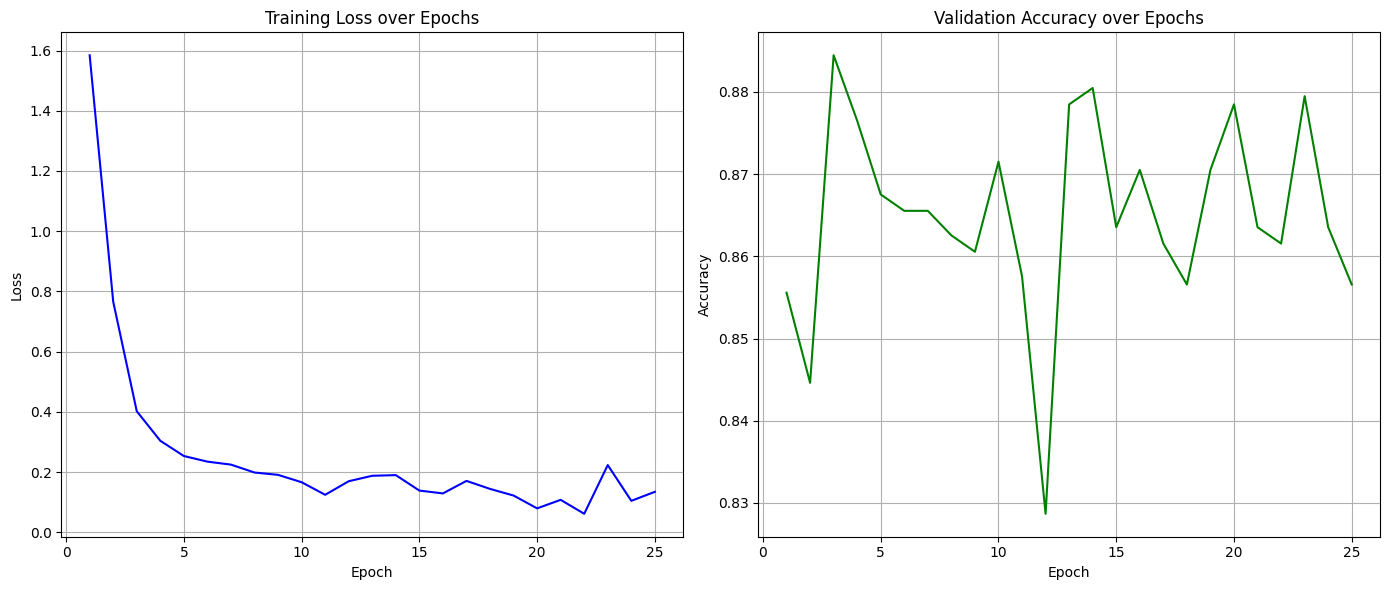

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Define model based on ResNet50 with custom heads for the 4 memorability classes
class MemorabilityModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(MemorabilityModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.iconic_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.contrast_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.symbolism_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.simplicity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.resnet(x)
        iconic = self.iconic_head(features)
        contrast = self.contrast_head(features)
        symbolism = self.symbolism_head(features)
        simplicity = self.simplicity_head(features)
        return iconic, contrast, symbolism, simplicity

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = MemorabilityModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resNet50_model.parameters(), lr=1e-4)

# Training settings
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            iconic, contrast, symbolism, simplicity = resNet50_model(images)

            # Fix here: replace .squeeze() with .view(-1)
            loss1 = criterion(iconic.view(-1), labels[:, 0])
            loss2 = criterion(contrast.view(-1), labels[:, 1])
            loss3 = criterion(symbolism.view(-1), labels[:, 2])
            loss4 = criterion(simplicity.view(-1), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(iconic),
                torch.sigmoid(contrast),
                torch.sigmoid(symbolism),
                torch.sigmoid(simplicity)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader):.4f}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            iconic, contrast, symbolism, simplicity = resNet50_model(images)

            pred1 = torch.sigmoid(iconic)
            pred2 = torch.sigmoid(contrast)
            pred3 = torch.sigmoid(symbolism)
            pred4 = torch.sigmoid(simplicity)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


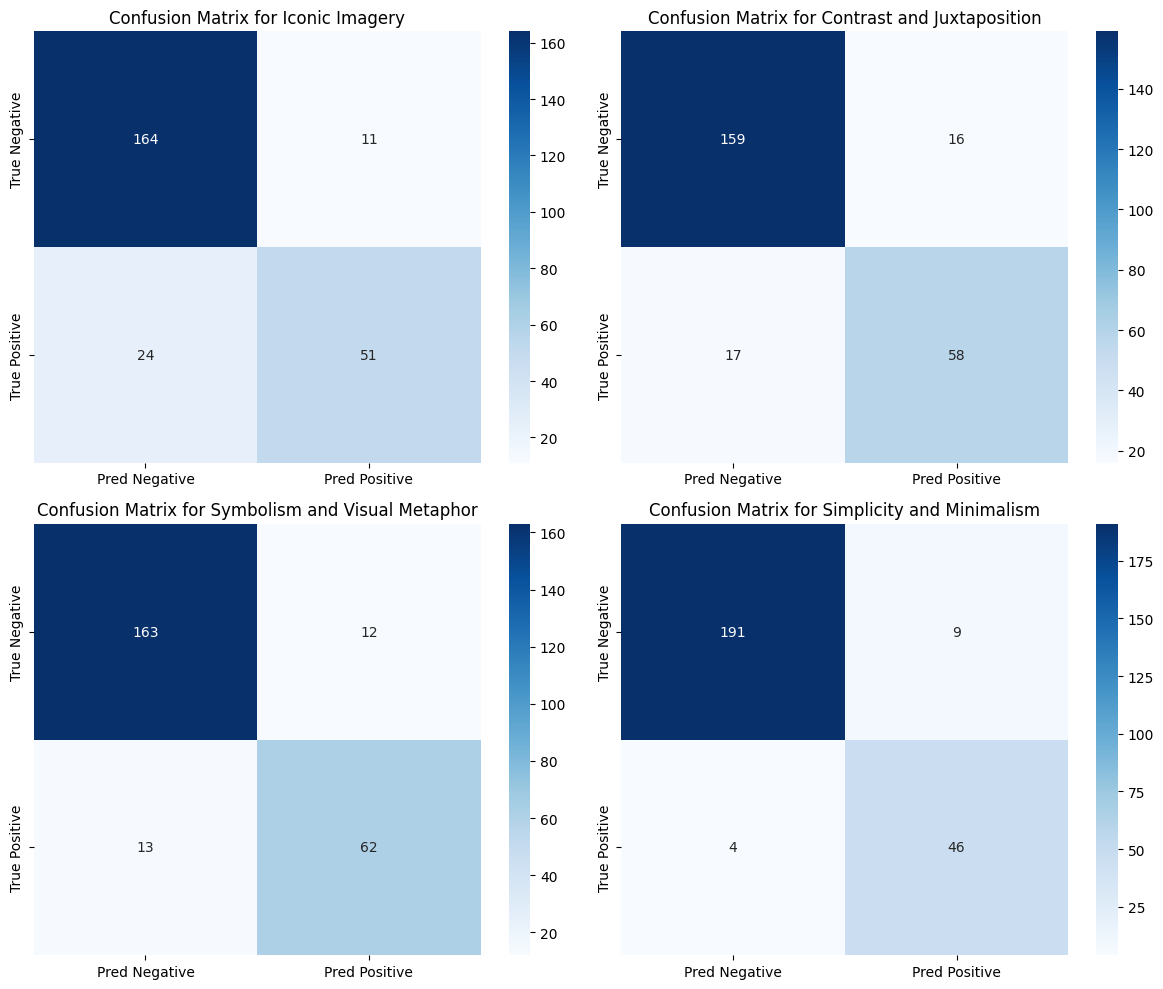

Test Accuracy: 89.40%
Precision: 80.20%
Recall: 80.00%
F1-Score: 79.53%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Set the model to evaluation mode
resNet50_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        iconic, contrast, symbolism, simplicity = resNet50_model(images)

        # Convert logits to probabilities using sigmoid
        pred_iconic = torch.sigmoid(iconic)
        pred_contrast = torch.sigmoid(contrast)
        pred_symbolism = torch.sigmoid(symbolism)
        pred_simplicity = torch.sigmoid(simplicity)

        # Binarize predictions (thresholding at 0.5)
        bin_iconic = (pred_iconic > 0.5).float()
        bin_contrast = (pred_contrast > 0.5).float()
        bin_symbolism = (pred_symbolism > 0.5).float()
        bin_simplicity = (pred_simplicity > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_iconic, bin_contrast, bin_symbolism, bin_simplicity], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {memorability_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 139MB/s]
Epoch 1/25 Training: 100%|██████████| 77/77 [00:53<00:00,  1.43batch/s, loss=2.14]


Epoch 1/25 completed in 53.91 seconds.
Epoch Loss: 1.5379
Train Accuracy: 82.64%


Validation Accuracy: 81.27%


Epoch 2/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.46batch/s, loss=3.91]


Epoch 2/25 completed in 52.84 seconds.
Epoch Loss: 0.7956
Train Accuracy: 92.34%


Validation Accuracy: 84.26%


Epoch 3/25 Training: 100%|██████████| 77/77 [00:53<00:00,  1.43batch/s, loss=2.15]


Epoch 3/25 completed in 54.00 seconds.
Epoch Loss: 0.4505
Train Accuracy: 96.28%


Validation Accuracy: 83.67%


Epoch 4/25 Training: 100%|██████████| 77/77 [00:56<00:00,  1.35batch/s, loss=2.97]


Epoch 4/25 completed in 56.85 seconds.
Epoch Loss: 0.3302
Train Accuracy: 97.44%


Validation Accuracy: 83.47%


Epoch 5/25 Training: 100%|██████████| 77/77 [00:53<00:00,  1.45batch/s, loss=6.64]


Epoch 5/25 completed in 53.06 seconds.
Epoch Loss: 0.2822
Train Accuracy: 98.43%


Validation Accuracy: 84.56%


Epoch 6/25 Training: 100%|██████████| 77/77 [00:53<00:00,  1.45batch/s, loss=5.39]


Epoch 6/25 completed in 53.23 seconds.
Epoch Loss: 0.3186
Train Accuracy: 97.77%


Validation Accuracy: 86.75%


Epoch 7/25 Training: 100%|██████████| 77/77 [00:59<00:00,  1.29batch/s, loss=2.8]


Epoch 7/25 completed in 59.81 seconds.
Epoch Loss: 0.2814
Train Accuracy: 97.73%


Validation Accuracy: 86.95%


Epoch 8/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=3.24]


Epoch 8/25 completed in 52.25 seconds.
Epoch Loss: 0.1459
Train Accuracy: 99.24%


Validation Accuracy: 87.35%


Epoch 9/25 Training: 100%|██████████| 77/77 [00:57<00:00,  1.34batch/s, loss=6.11]


Epoch 9/25 completed in 57.63 seconds.
Epoch Loss: 0.2054
Train Accuracy: 98.98%


Validation Accuracy: 84.66%


Epoch 10/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=2.9]


Epoch 10/25 completed in 52.32 seconds.
Epoch Loss: 0.1816
Train Accuracy: 98.77%


Validation Accuracy: 86.16%


Epoch 11/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.46batch/s, loss=1.23]


Epoch 11/25 completed in 52.70 seconds.
Epoch Loss: 0.1559
Train Accuracy: 98.62%


Validation Accuracy: 84.86%


Epoch 12/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=6.17]


Epoch 12/25 completed in 52.10 seconds.
Epoch Loss: 0.1939
Train Accuracy: 99.00%


Validation Accuracy: 84.66%


Epoch 13/25 Training: 100%|██████████| 77/77 [00:51<00:00,  1.48batch/s, loss=2.75]


Epoch 13/25 completed in 51.91 seconds.
Epoch Loss: 0.1633
Train Accuracy: 98.82%


Validation Accuracy: 86.55%


Epoch 14/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=5.07]


Epoch 14/25 completed in 52.25 seconds.
Epoch Loss: 0.1911
Train Accuracy: 98.91%


Validation Accuracy: 85.96%


Epoch 15/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=2.86]


Epoch 15/25 completed in 52.11 seconds.
Epoch Loss: 0.1455
Train Accuracy: 99.09%


Validation Accuracy: 84.36%


Epoch 16/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=5.84]


Epoch 16/25 completed in 52.38 seconds.
Epoch Loss: 0.1854
Train Accuracy: 99.08%


Validation Accuracy: 84.96%


Epoch 17/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=5.66]


Epoch 17/25 completed in 52.35 seconds.
Epoch Loss: 0.1747
Train Accuracy: 99.20%


Validation Accuracy: 85.56%


Epoch 18/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=5.63]


Epoch 18/25 completed in 52.16 seconds.
Epoch Loss: 0.1388
Train Accuracy: 99.39%


Validation Accuracy: 85.26%


Epoch 19/25 Training: 100%|██████████| 77/77 [00:51<00:00,  1.48batch/s, loss=1.61]


Epoch 19/25 completed in 51.90 seconds.
Epoch Loss: 0.0741
Train Accuracy: 99.61%


Validation Accuracy: 84.66%


Epoch 20/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=6.11]


Epoch 20/25 completed in 52.07 seconds.
Epoch Loss: 0.1139
Train Accuracy: 99.76%


Validation Accuracy: 87.05%


Epoch 21/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=6.13]


Epoch 21/25 completed in 52.17 seconds.
Epoch Loss: 0.1775
Train Accuracy: 99.21%


Validation Accuracy: 83.96%


Epoch 22/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=3.23]


Epoch 22/25 completed in 52.11 seconds.
Epoch Loss: 0.1234
Train Accuracy: 99.28%


Validation Accuracy: 86.85%


Epoch 23/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.47batch/s, loss=3.03]


Epoch 23/25 completed in 52.23 seconds.
Epoch Loss: 0.1075
Train Accuracy: 99.50%


Validation Accuracy: 87.05%


Epoch 24/25 Training: 100%|██████████| 77/77 [00:52<00:00,  1.48batch/s, loss=4.26]


Epoch 24/25 completed in 52.03 seconds.
Epoch Loss: 0.2290
Train Accuracy: 98.66%


Validation Accuracy: 82.87%


Epoch 25/25 Training: 100%|██████████| 77/77 [00:51<00:00,  1.48batch/s, loss=4.86]


Epoch 25/25 completed in 51.99 seconds.
Epoch Loss: 0.2092
Train Accuracy: 98.85%


Validation Accuracy: 89.14%

Total Training Time: 1385.56 seconds (23.09 minutes)


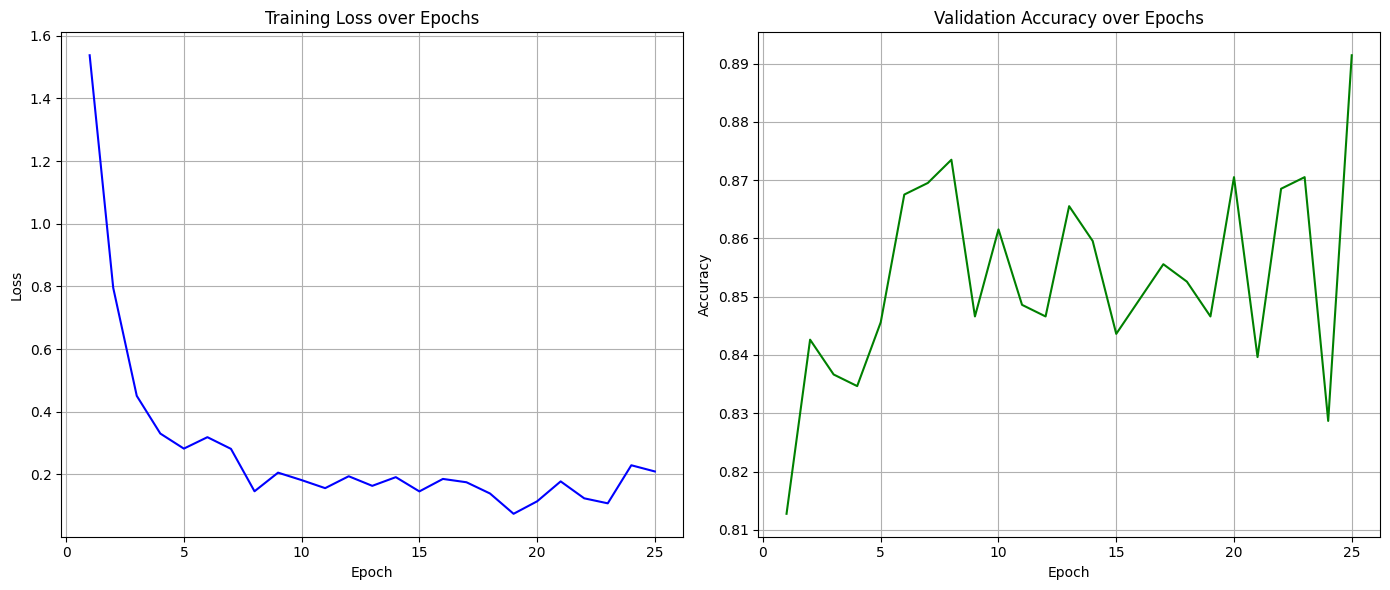

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Define model based on ResNet101 with custom heads for the 4 memorability classes
class MemorabilityModelWithResNet101(nn.Module):
    def __init__(self, num_classes=4):
        super(MemorabilityModelWithResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.iconic_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.contrast_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.symbolism_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.simplicity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.resnet(x)
        iconic = self.iconic_head(features)
        contrast = self.contrast_head(features)
        symbolism = self.symbolism_head(features)
        simplicity = self.simplicity_head(features)
        return iconic, contrast, symbolism, simplicity

# Initialize model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet101_model = MemorabilityModelWithResNet101().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resNet101_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resNet101_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            iconic, contrast, symbolism, simplicity = resNet101_model(images)

            # use .view(-1) to avoid squeeze shape mismatch
            loss1 = criterion(iconic.view(-1), labels[:, 0])
            loss2 = criterion(contrast.view(-1), labels[:, 1])
            loss3 = criterion(symbolism.view(-1), labels[:, 2])
            loss4 = criterion(simplicity.view(-1), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(iconic),
                torch.sigmoid(contrast),
                torch.sigmoid(symbolism),
                torch.sigmoid(simplicity)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader):.4f}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation
    resNet101_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            iconic, contrast, symbolism, simplicity = resNet101_model(images)

            pred1 = torch.sigmoid(iconic)
            pred2 = torch.sigmoid(contrast)
            pred3 = torch.sigmoid(symbolism)
            pred4 = torch.sigmoid(simplicity)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


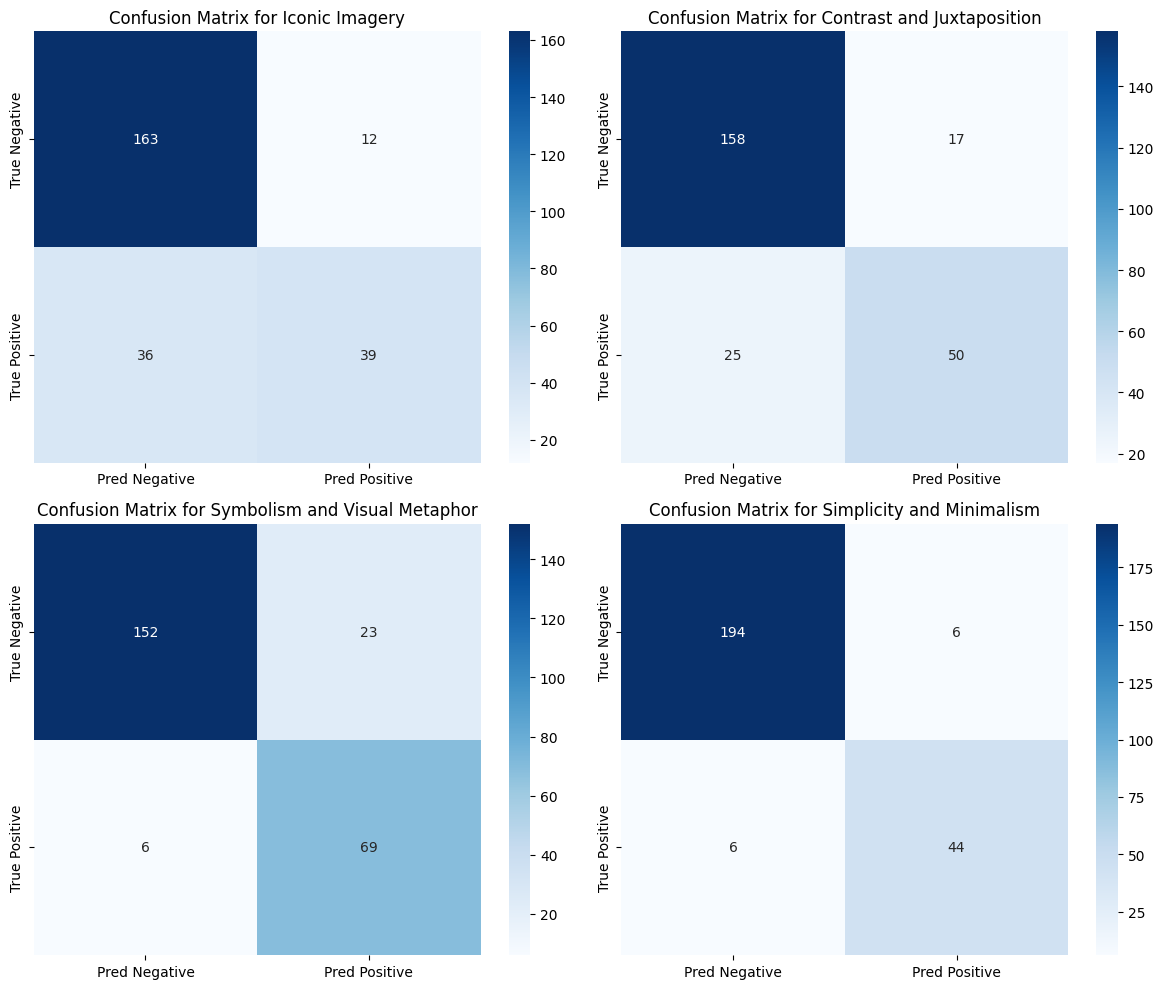

Test Accuracy: 86.90%
Precision: 73.73%
Recall: 73.60%
F1-Score: 73.27%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Set the model to evaluation mode
resNet101_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        iconic, contrast, symbolism, simplicity = resNet101_model(images)

        # Convert logits to probabilities using sigmoid
        pred_iconic = torch.sigmoid(iconic)
        pred_contrast = torch.sigmoid(contrast)
        pred_symbolism = torch.sigmoid(symbolism)
        pred_simplicity = torch.sigmoid(simplicity)

        # Binarize predictions (thresholding at 0.5)
        bin_iconic = (pred_iconic > 0.5).float()
        bin_contrast = (pred_contrast > 0.5).float()
        bin_symbolism = (pred_symbolism > 0.5).float()
        bin_simplicity = (pred_simplicity > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_iconic, bin_contrast, bin_symbolism, bin_simplicity], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {memorability_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 77/77 [01:31<00:00,  1.18s/batch, loss=1.14]


Epoch 1/25 completed in 91.22 seconds.
Epoch Loss: 1.8231
Train Accuracy: 78.11%


Validation Accuracy: 78.39%


Epoch 2/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.778]


Epoch 2/25 completed in 90.56 seconds.
Epoch Loss: 1.2250
Train Accuracy: 86.60%


Validation Accuracy: 80.18%


Epoch 3/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.231]


Epoch 3/25 completed in 90.40 seconds.
Epoch Loss: 0.7986
Train Accuracy: 91.71%


Validation Accuracy: 79.18%


Epoch 4/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.0282]


Epoch 4/25 completed in 90.58 seconds.
Epoch Loss: 0.4908
Train Accuracy: 95.41%


Validation Accuracy: 81.47%


Epoch 5/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=6.42]


Epoch 5/25 completed in 90.70 seconds.
Epoch Loss: 0.3183
Train Accuracy: 97.98%


Validation Accuracy: 79.78%


Epoch 6/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.0196]


Epoch 6/25 completed in 90.44 seconds.
Epoch Loss: 0.7225
Train Accuracy: 92.87%


Validation Accuracy: 81.57%


Epoch 7/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.0126]


Epoch 7/25 completed in 90.26 seconds.
Epoch Loss: 0.1922
Train Accuracy: 98.36%


Validation Accuracy: 82.37%


Epoch 8/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.00775]


Epoch 8/25 completed in 90.45 seconds.
Epoch Loss: 0.1687
Train Accuracy: 98.57%


Validation Accuracy: 83.57%


Epoch 9/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.0099]


Epoch 9/25 completed in 90.36 seconds.
Epoch Loss: 0.1440
Train Accuracy: 98.83%


Validation Accuracy: 84.66%


Epoch 10/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.00185]


Epoch 10/25 completed in 90.84 seconds.
Epoch Loss: 0.0926
Train Accuracy: 99.16%


Validation Accuracy: 83.17%


Epoch 11/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.0018]


Epoch 11/25 completed in 90.68 seconds.
Epoch Loss: 0.1058
Train Accuracy: 99.06%


Validation Accuracy: 79.58%


Epoch 12/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.00372]


Epoch 12/25 completed in 90.34 seconds.
Epoch Loss: 0.1448
Train Accuracy: 98.60%


Validation Accuracy: 82.97%


Epoch 13/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.00396]


Epoch 13/25 completed in 90.47 seconds.
Epoch Loss: 0.0942
Train Accuracy: 99.29%


Validation Accuracy: 82.87%


Epoch 14/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.00321]


Epoch 14/25 completed in 90.79 seconds.
Epoch Loss: 0.1156
Train Accuracy: 99.03%


Validation Accuracy: 82.87%


Epoch 15/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.0349]


Epoch 15/25 completed in 90.42 seconds.
Epoch Loss: 0.1847
Train Accuracy: 98.63%


Validation Accuracy: 82.77%


Epoch 16/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.00217]


Epoch 16/25 completed in 90.46 seconds.
Epoch Loss: 0.1204
Train Accuracy: 99.02%


Validation Accuracy: 82.17%


Epoch 17/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.00904]


Epoch 17/25 completed in 90.71 seconds.
Epoch Loss: 0.1089
Train Accuracy: 99.14%


Validation Accuracy: 80.08%


Epoch 18/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.00654]


Epoch 18/25 completed in 90.83 seconds.
Epoch Loss: 0.1226
Train Accuracy: 98.90%


Validation Accuracy: 81.67%


Epoch 19/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.000997]


Epoch 19/25 completed in 90.81 seconds.
Epoch Loss: 0.0898
Train Accuracy: 99.19%


Validation Accuracy: 84.46%


Epoch 20/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.17s/batch, loss=0.00045]


Epoch 20/25 completed in 90.39 seconds.
Epoch Loss: 0.0326
Train Accuracy: 99.75%


Validation Accuracy: 83.86%


Epoch 21/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.00423]


Epoch 21/25 completed in 90.65 seconds.
Epoch Loss: 0.0150
Train Accuracy: 99.92%


Validation Accuracy: 83.47%


Epoch 22/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.000662]


Epoch 22/25 completed in 90.63 seconds.
Epoch Loss: 0.0126
Train Accuracy: 99.89%


Validation Accuracy: 83.27%


Epoch 23/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.000527]


Epoch 23/25 completed in 90.57 seconds.
Epoch Loss: 0.0942
Train Accuracy: 99.18%


Validation Accuracy: 76.89%


Epoch 24/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.256]


Epoch 24/25 completed in 90.52 seconds.
Epoch Loss: 0.1610
Train Accuracy: 98.80%


Validation Accuracy: 81.08%


Epoch 25/25 Training: 100%|██████████| 77/77 [01:30<00:00,  1.18s/batch, loss=0.761]


Epoch 25/25 completed in 90.51 seconds.
Epoch Loss: 0.2158
Train Accuracy: 98.14%


Validation Accuracy: 81.27%

Total Training Time: 2353.21 seconds (39.22 minutes)


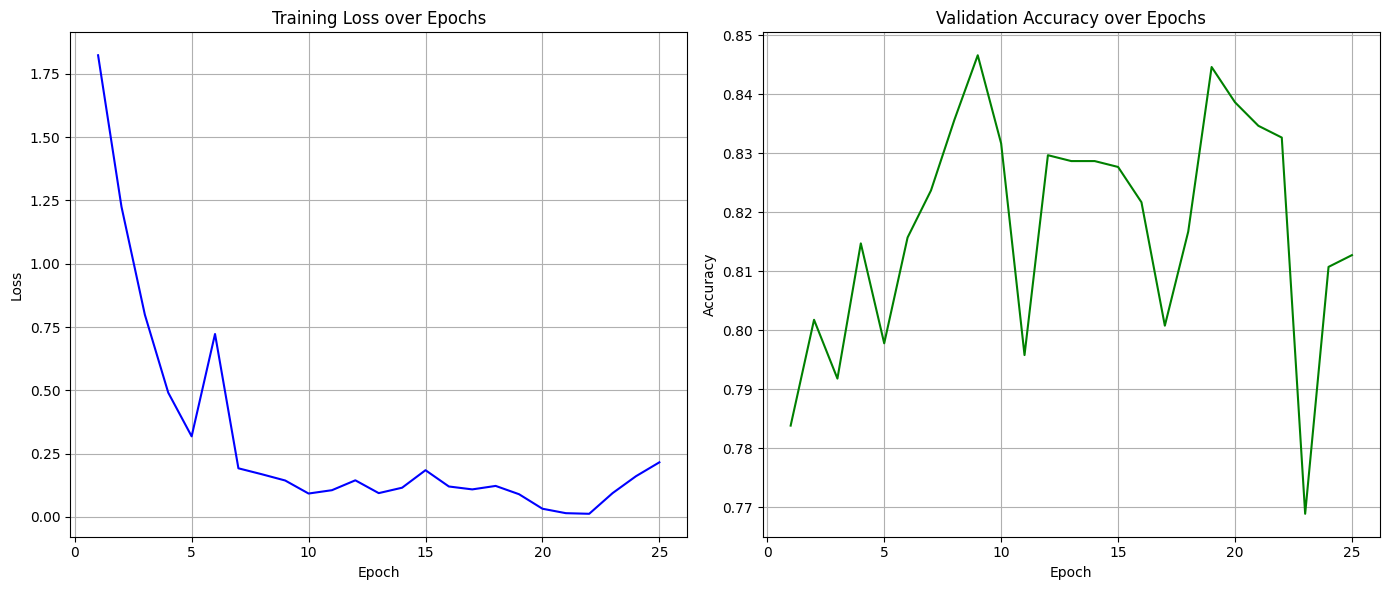

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Define model based on ViT with custom heads for the 4 memorability classes
class MemorabilityModelWithViT(nn.Module):
    def __init__(self, backbone_name="vit_base_patch16_224", num_classes=4):
        super(MemorabilityModelWithViT, self).__init__()
        self.vit = timm.create_model(backbone_name, pretrained=True)

        # Get the output feature dimension of the ViT
        in_features = self.vit.head.in_features
        self.vit.head = nn.Identity()  # Remove the classification head

        # Define 4 custom heads for each memorability category
        self.iconic_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.contrast_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.symbolism_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.simplicity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.vit(x)
        return (
            self.iconic_head(features),
            self.contrast_head(features),
            self.symbolism_head(features),
            self.simplicity_head(features)
        )

# Initialize model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = MemorabilityModelWithViT().to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Training settings
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            iconic, contrast, symbolism, simplicity = vit_model(images)

            # Use .view(-1) to avoid squeeze shape mismatch
            loss1 = criterion(iconic.view(-1), labels[:, 0])
            loss2 = criterion(contrast.view(-1), labels[:, 1])
            loss3 = criterion(symbolism.view(-1), labels[:, 2])
            loss4 = criterion(simplicity.view(-1), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(iconic),
                torch.sigmoid(contrast),
                torch.sigmoid(symbolism),
                torch.sigmoid(simplicity)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader):.4f}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    vit_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            iconic, contrast, symbolism, simplicity = vit_model(images)

            pred1 = torch.sigmoid(iconic)
            pred2 = torch.sigmoid(contrast)
            pred3 = torch.sigmoid(symbolism)
            pred4 = torch.sigmoid(simplicity)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


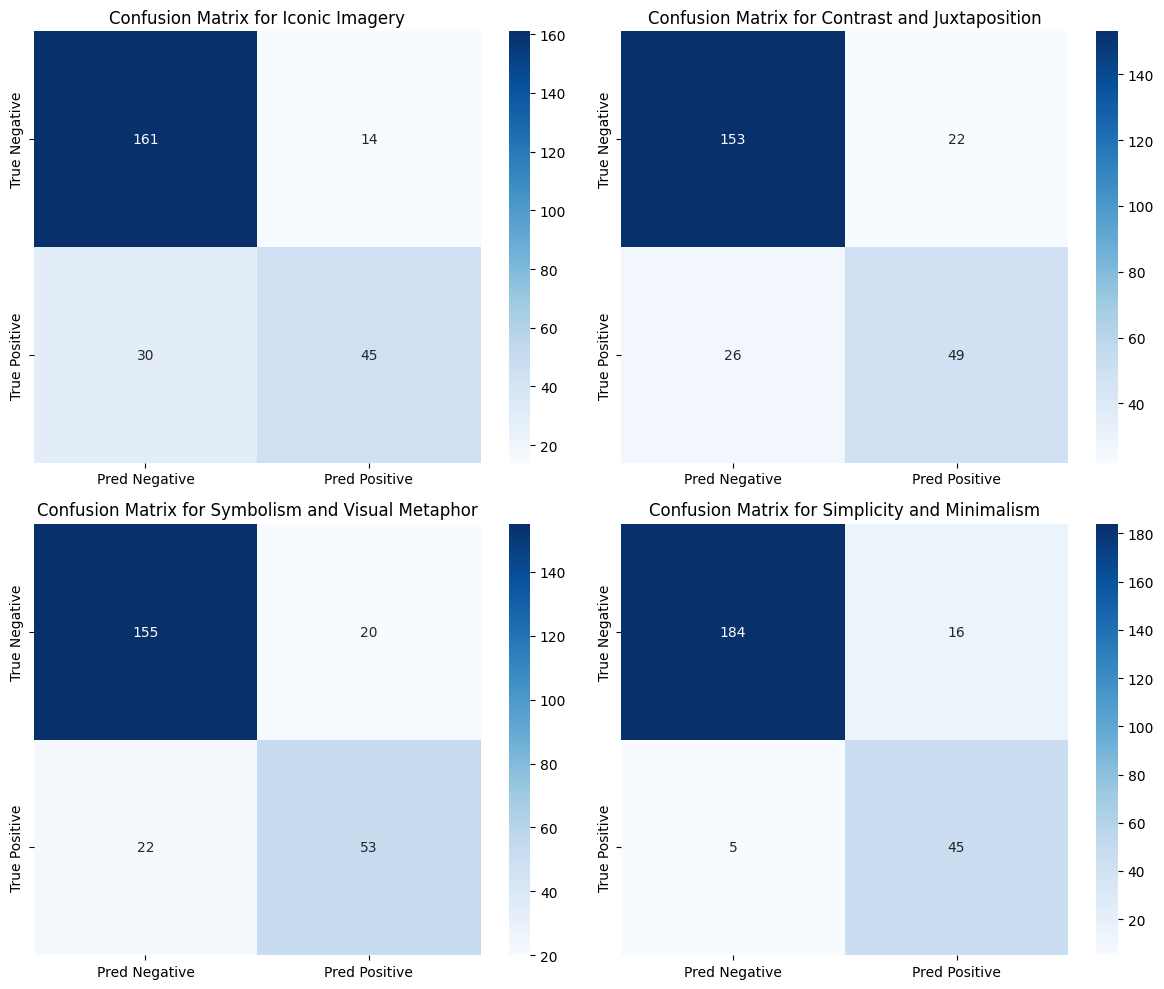

Test Accuracy: 84.50%
Precision: 71.27%
Recall: 70.80%
F1-Score: 70.39%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Set the model to evaluation mode
vit_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        iconic, contrast, symbolism, simplicity = vit_model(images)

        # Convert logits to probabilities using sigmoid
        pred_iconic = torch.sigmoid(iconic)
        pred_contrast = torch.sigmoid(contrast)
        pred_symbolism = torch.sigmoid(symbolism)
        pred_simplicity = torch.sigmoid(simplicity)

        # Binarize predictions (thresholding at 0.5)
        bin_iconic = (pred_iconic > 0.5).float()
        bin_contrast = (pred_contrast > 0.5).float()
        bin_symbolism = (pred_symbolism > 0.5).float()
        bin_simplicity = (pred_simplicity > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_iconic, bin_contrast, bin_symbolism, bin_simplicity], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {memorability_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 77/77 [00:39<00:00,  1.93batch/s, loss=3.26]


Epoch 1/25 completed in 39.93 seconds.
Epoch Loss: 2.1084
Train Accuracy: 74.50%


Validation Accuracy: 80.38%


Epoch 2/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.10batch/s, loss=2.18]


Epoch 2/25 completed in 36.60 seconds.
Epoch Loss: 1.1910
Train Accuracy: 87.31%


Validation Accuracy: 84.56%


Epoch 3/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.05batch/s, loss=2.86]


Epoch 3/25 completed in 37.63 seconds.
Epoch Loss: 0.5658
Train Accuracy: 95.25%


Validation Accuracy: 86.06%


Epoch 4/25 Training: 100%|██████████| 77/77 [00:47<00:00,  1.62batch/s, loss=4.6]


Epoch 4/25 completed in 47.59 seconds.
Epoch Loss: 0.2892
Train Accuracy: 98.22%


Validation Accuracy: 85.86%


Epoch 5/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=3.12]


Epoch 5/25 completed in 37.15 seconds.
Epoch Loss: 0.1555
Train Accuracy: 99.32%


Validation Accuracy: 87.15%


Epoch 6/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=4.39]


Epoch 6/25 completed in 37.11 seconds.
Epoch Loss: 0.1219
Train Accuracy: 99.65%


Validation Accuracy: 87.45%


Epoch 7/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.06batch/s, loss=3.3]


Epoch 7/25 completed in 37.42 seconds.
Epoch Loss: 0.0991
Train Accuracy: 99.71%


Validation Accuracy: 88.25%


Epoch 8/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=1.75]


Epoch 8/25 completed in 37.12 seconds.
Epoch Loss: 0.0714
Train Accuracy: 99.70%


Validation Accuracy: 89.04%


Epoch 9/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=7.3]


Epoch 9/25 completed in 37.13 seconds.
Epoch Loss: 0.1244
Train Accuracy: 99.83%


Validation Accuracy: 89.34%


Epoch 10/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=6.62]


Epoch 10/25 completed in 37.01 seconds.
Epoch Loss: 0.1230
Train Accuracy: 99.76%


Validation Accuracy: 87.25%


Epoch 11/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=2.61]


Epoch 11/25 completed in 37.15 seconds.
Epoch Loss: 0.0690
Train Accuracy: 99.76%


Validation Accuracy: 88.65%


Epoch 12/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=5.25]


Epoch 12/25 completed in 36.93 seconds.
Epoch Loss: 0.1101
Train Accuracy: 99.68%


Validation Accuracy: 87.85%


Epoch 13/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.09batch/s, loss=2.28]


Epoch 13/25 completed in 36.92 seconds.
Epoch Loss: 0.0600
Train Accuracy: 99.79%


Validation Accuracy: 88.05%


Epoch 14/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=3.82]


Epoch 14/25 completed in 37.12 seconds.
Epoch Loss: 0.0924
Train Accuracy: 99.69%


Validation Accuracy: 87.95%


Epoch 15/25 Training: 100%|██████████| 77/77 [00:43<00:00,  1.76batch/s, loss=1.74]


Epoch 15/25 completed in 43.69 seconds.
Epoch Loss: 0.0592
Train Accuracy: 99.73%


Validation Accuracy: 85.16%


Epoch 16/25 Training: 100%|██████████| 77/77 [00:38<00:00,  1.99batch/s, loss=5.92]


Epoch 16/25 completed in 38.71 seconds.
Epoch Loss: 0.1030
Train Accuracy: 99.83%


Validation Accuracy: 87.25%


Epoch 17/25 Training: 100%|██████████| 77/77 [00:36<00:00,  2.08batch/s, loss=1.51]


Epoch 17/25 completed in 36.96 seconds.
Epoch Loss: 0.0635
Train Accuracy: 99.68%


Validation Accuracy: 87.45%


Epoch 18/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=0.649]


Epoch 18/25 completed in 37.21 seconds.
Epoch Loss: 0.0402
Train Accuracy: 99.82%


Validation Accuracy: 88.15%


Epoch 19/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=2.62]


Epoch 19/25 completed in 37.06 seconds.
Epoch Loss: 0.0563
Train Accuracy: 99.83%


Validation Accuracy: 88.25%


Epoch 20/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=0.719]


Epoch 20/25 completed in 37.02 seconds.
Epoch Loss: 0.0342
Train Accuracy: 99.83%


Validation Accuracy: 88.35%


Epoch 21/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=6.95]


Epoch 21/25 completed in 37.19 seconds.
Epoch Loss: 0.1142
Train Accuracy: 99.79%


Validation Accuracy: 87.45%


Epoch 22/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=3.37]


Epoch 22/25 completed in 37.05 seconds.
Epoch Loss: 0.0650
Train Accuracy: 99.85%


Validation Accuracy: 87.75%


Epoch 23/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.07batch/s, loss=2.35]


Epoch 23/25 completed in 37.18 seconds.
Epoch Loss: 0.0600
Train Accuracy: 99.79%


Validation Accuracy: 87.15%


Epoch 24/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=6.15]


Epoch 24/25 completed in 37.06 seconds.
Epoch Loss: 0.1041
Train Accuracy: 99.84%


Validation Accuracy: 88.15%


Epoch 25/25 Training: 100%|██████████| 77/77 [00:37<00:00,  2.08batch/s, loss=1.97]


Epoch 25/25 completed in 37.10 seconds.
Epoch Loss: 0.0584
Train Accuracy: 99.74%


Validation Accuracy: 88.75%

Total Training Time: 992.40 seconds (16.54 minutes)


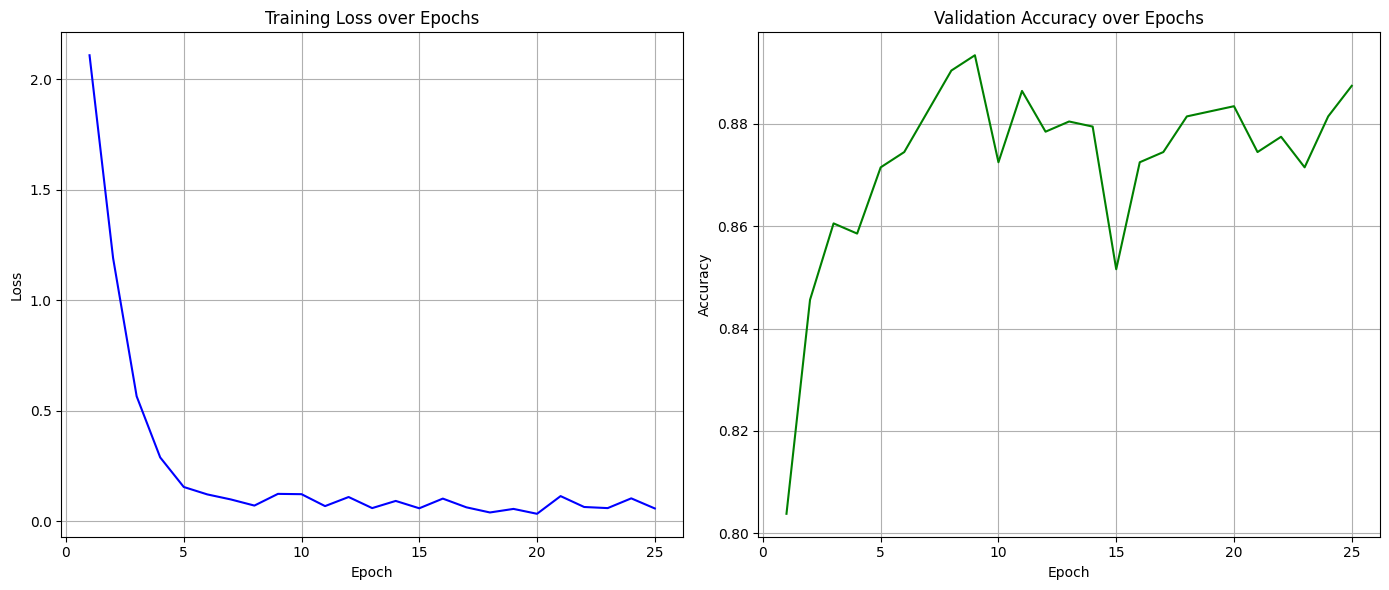

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Define model based on EfficientNet with custom heads
class MemorabilityModelWithEfficientNet(nn.Module):
    def __init__(self, backbone_name="efficientnet_b3", num_classes=4):
        super(MemorabilityModelWithEfficientNet, self).__init__()
        self.efficientnet = timm.create_model(backbone_name, pretrained=True)

        # Get the output features and remove classification head
        in_features = self.efficientnet.classifier.in_features
        self.efficientnet.classifier = nn.Identity()

        # Define 4 heads for each memorability category
        self.iconic_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.contrast_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.symbolism_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.simplicity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.efficientnet(x)
        return (
            self.iconic_head(features),
            self.contrast_head(features),
            self.symbolism_head(features),
            self.simplicity_head(features)
        )

# Initialize model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet_model = MemorabilityModelWithEfficientNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    effnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            iconic, contrast, symbolism, simplicity = effnet_model(images)

            # Compute losses
            loss1 = criterion(iconic.view(-1), labels[:, 0])
            loss2 = criterion(contrast.view(-1), labels[:, 1])
            loss3 = criterion(symbolism.view(-1), labels[:, 2])
            loss4 = criterion(simplicity.view(-1), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(iconic),
                torch.sigmoid(contrast),
                torch.sigmoid(symbolism),
                torch.sigmoid(simplicity)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader):.4f}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation
    effnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            iconic, contrast, symbolism, simplicity = effnet_model(images)

            pred1 = torch.sigmoid(iconic)
            pred2 = torch.sigmoid(contrast)
            pred3 = torch.sigmoid(symbolism)
            pred4 = torch.sigmoid(simplicity)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


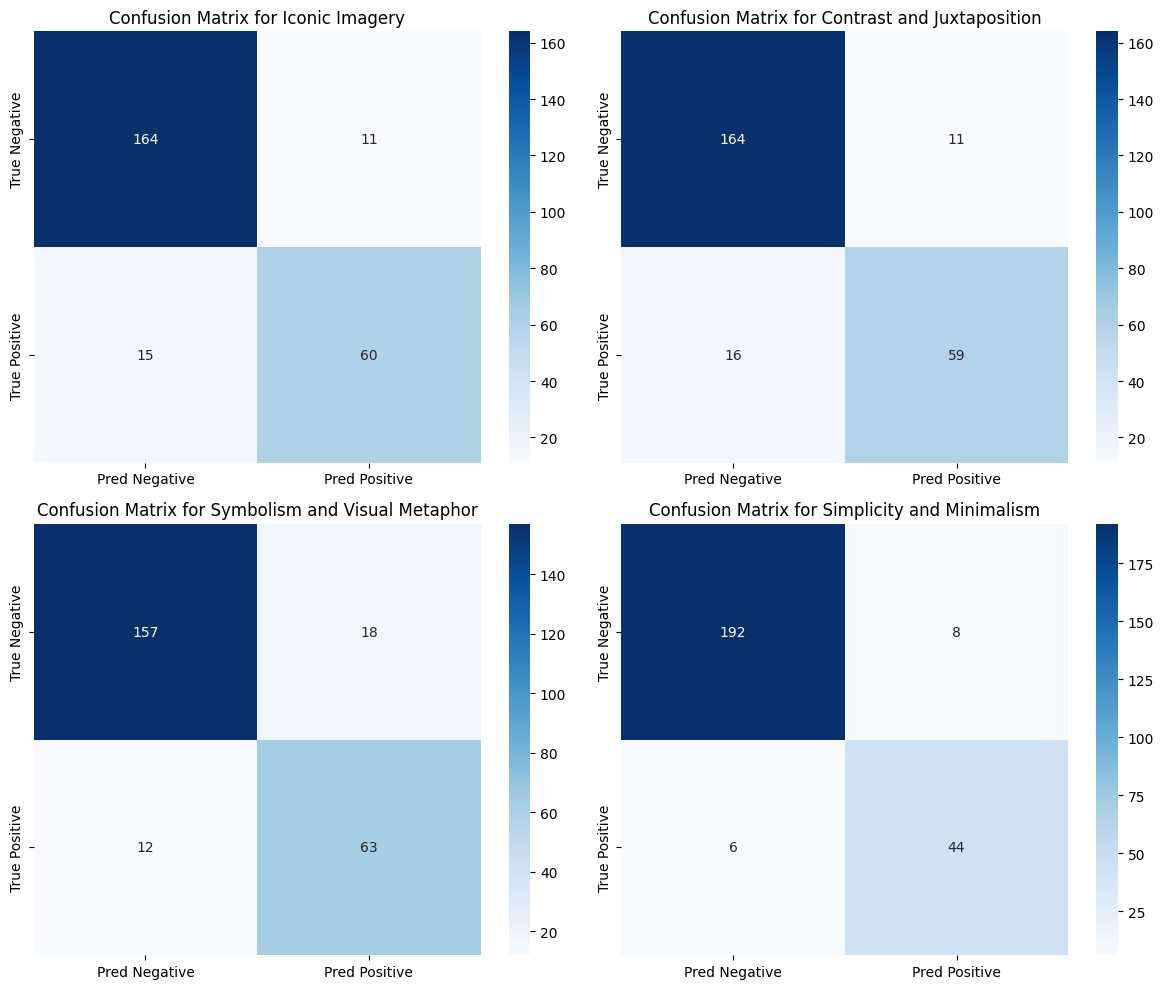

Test Accuracy: 90.30%
Precision: 81.80%
Recall: 83.40%
F1-Score: 82.00%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Set the model to evaluation mode
effnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        iconic, contrast, symbolism, simplicity = effnet_model(images)

        # Convert logits to probabilities using sigmoid
        pred_iconic = torch.sigmoid(iconic)
        pred_contrast = torch.sigmoid(contrast)
        pred_symbolism = torch.sigmoid(symbolism)
        pred_simplicity = torch.sigmoid(simplicity)

        # Binarize predictions (thresholding at 0.5)
        bin_iconic = (pred_iconic > 0.5).float()
        bin_contrast = (pred_contrast > 0.5).float()
        bin_symbolism = (pred_symbolism > 0.5).float()
        bin_simplicity = (pred_simplicity > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_iconic, bin_contrast, bin_symbolism, bin_simplicity], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {memorability_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


In [ ]:
import torch

# Assuming you have a model defined as `model`
# Example:
# model = AestheticModel()  # Replace with your actual model definition

# Convert the model to TorchScript (this assumes the model's forward function is compatible)
scripted_model = torch.jit.script(effnet_model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/memorability_effnet_model.pth")

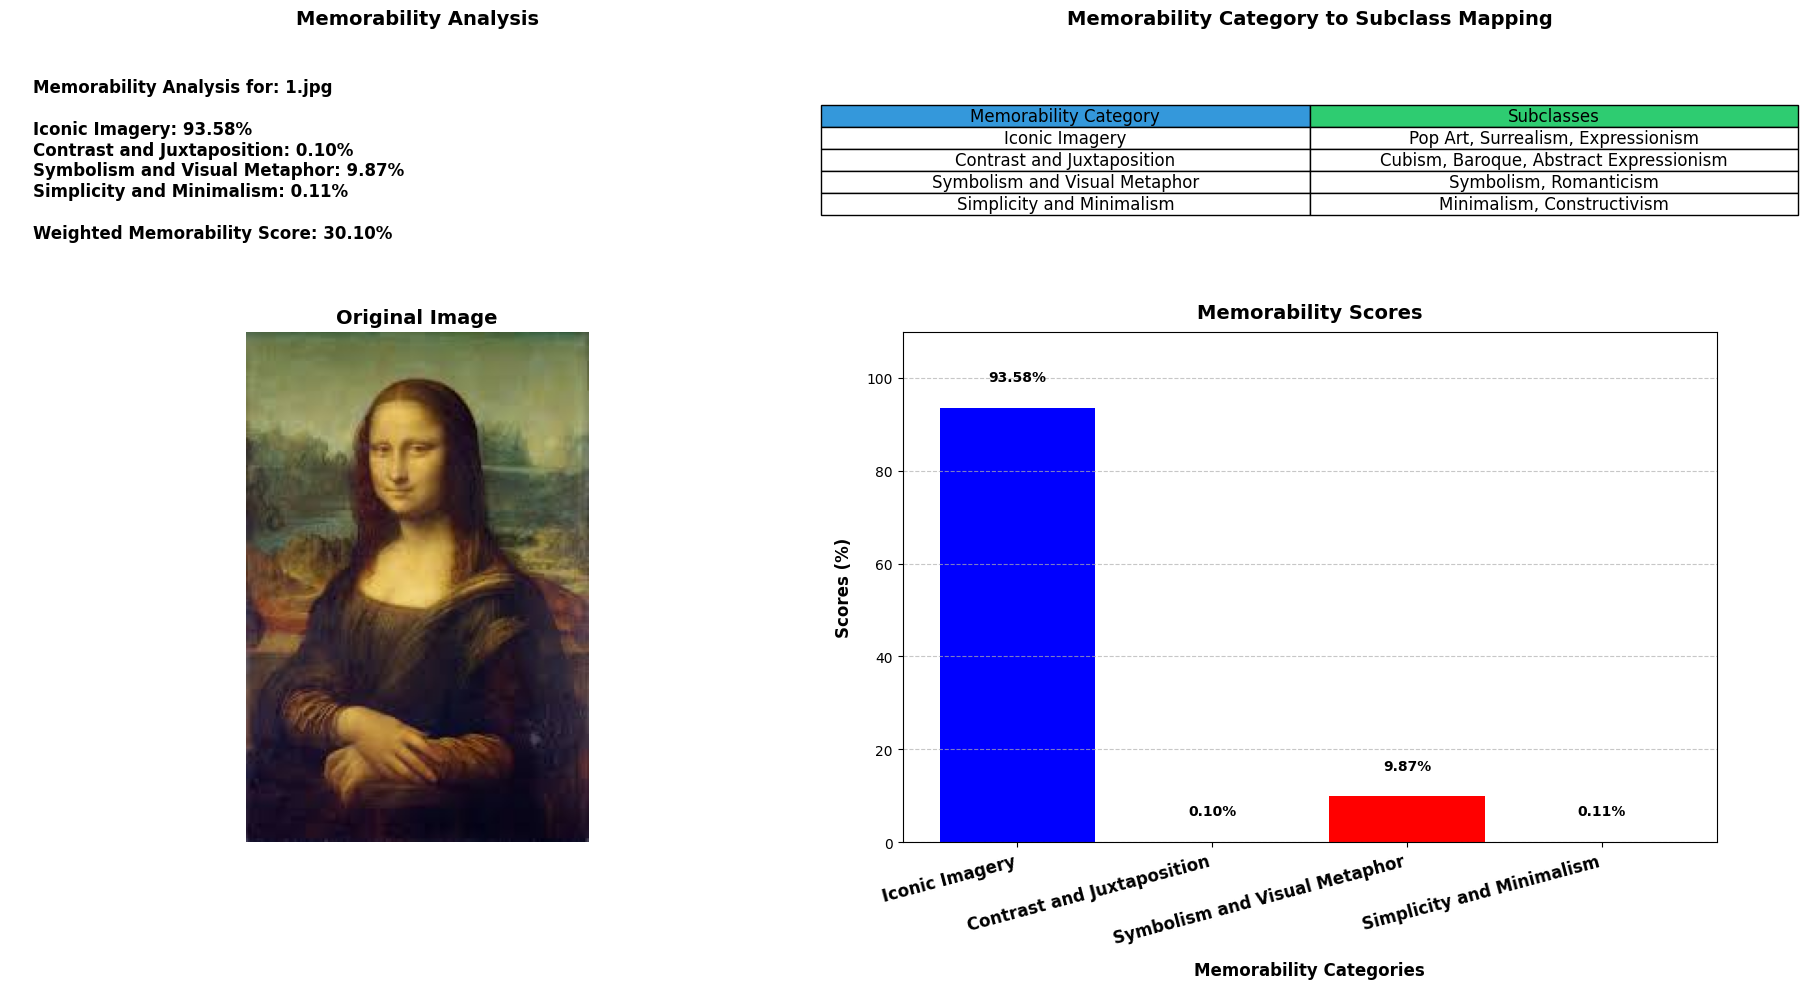

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image

# Load TorchScript memorability model
scripted_model = torch.jit.load("/content/CSE499-MerakiNexus-AI_And_Defi/memorability_model/models/memorability_effnet_model.pth")  # adjust path
scripted_model.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# Define memorability categories and weights
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

weights = {
    "Iconic Imagery": 0.3,
    "Contrast and Juxtaposition": 0.3,
    "Symbolism and Visual Metaphor": 0.2,
    "Simplicity and Minimalism": 0.2
}

category_to_subclasses = {
    "Iconic Imagery": ["Pop Art", "Surrealism", "Expressionism"],
    "Contrast and Juxtaposition": ["Cubism", "Baroque", "Abstract Expressionism"],
    "Symbolism and Visual Metaphor": ["Symbolism", "Romanticism"],
    "Simplicity and Minimalism": ["Minimalism", "Constructivism"]
}

# Preprocess function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

# Inference
def run_inference(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        outputs = scripted_model(image_tensor)

        iconic, contrast, symbolism, simplicity = outputs  # Assuming 4 separate outputs

        scores = {
            "Iconic Imagery": torch.sigmoid(iconic).item() * 100,
            "Contrast and Juxtaposition": torch.sigmoid(contrast).item() * 100,
            "Symbolism and Visual Metaphor": torch.sigmoid(symbolism).item() * 100,
            "Simplicity and Minimalism": torch.sigmoid(simplicity).item() * 100
        }

    return scores

# Visualize results
def visualize_memorability_scores(image_path):
    scores = run_inference(image_path)
    weighted_score = sum(scores[k] * weights[k] for k in scores)

    mapping_df = pd.DataFrame(
        [(cat, ", ".join(subs)) for cat, subs in category_to_subclasses.items()],
        columns=["Memorability Category", "Subclasses"]
    )

    fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2]})

    # Text block
    summary = f"""
    Memorability Analysis for: {image_path}

    Iconic Imagery: {scores['Iconic Imagery']:.2f}%
    Contrast and Juxtaposition: {scores['Contrast and Juxtaposition']:.2f}%
    Symbolism and Visual Metaphor: {scores['Symbolism and Visual Metaphor']:.2f}%
    Simplicity and Minimalism: {scores['Simplicity and Minimalism']:.2f}%

    Weighted Memorability Score: {weighted_score:.2f}%
    """
    axes[0, 0].text(0, 0.5, summary, fontsize=12, fontweight="bold",
                    verticalalignment='center', horizontalalignment='left')
    axes[0, 0].axis("off")
    axes[0, 0].set_title("Memorability Analysis", fontsize=14, fontweight="bold")

    # Table
    axes[0, 1].axis("tight")
    axes[0, 1].axis("off")
    table = axes[0, 1].table(
        cellText=mapping_df.values,
        colLabels=mapping_df.columns,
        cellLoc="center",
        loc="center",
        colColours=["#3498db", "#2ecc71"]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axes[0, 1].set_title("Memorability Category to Subclass Mapping", fontsize=14, fontweight="bold")

    # Original image
    image = Image.open(image_path)
    axes[1, 0].imshow(image)
    axes[1, 0].axis("off")
    axes[1, 0].set_title("Original Image", fontsize=14, fontweight='bold')

    # Bar chart
    bars = axes[1, 1].bar(scores.keys(), scores.values(), color=['blue', 'green', 'red', 'orange'])
    for bar in bars:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 5,
                        f'{bar.get_height():.2f}%',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[1, 1].set_xticks(range(len(scores)))
    axes[1, 1].set_xticklabels(scores.keys(), fontsize=12, fontweight='bold', rotation=15, ha='right')
    axes[1, 1].set_xlabel('Memorability Categories', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_ylabel('Scores (%)', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_title('Memorability Scores', fontsize=14, fontweight='bold', pad=10)
    axes[1, 1].set_ylim(0, 110)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Example usage
image_path = "1.jpg"  # 🔁 Replace with your image path
visualize_memorability_scores(image_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 43.4MB/s]
Epoch 1/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.44batch/s, loss=1.64]


Epoch 1 completed in 17.36 seconds.
Epoch Loss: 1.8156
Train Accuracy: 77.74%


Validation Accuracy: 79.98%


Epoch 2/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.31batch/s, loss=0.93]


Epoch 2 completed in 17.87 seconds.
Epoch Loss: 1.2736
Train Accuracy: 85.53%


Validation Accuracy: 82.97%


Epoch 3/25 Training: 100%|██████████| 77/77 [00:18<00:00,  4.27batch/s, loss=0.185]


Epoch 3 completed in 18.03 seconds.
Epoch Loss: 0.8380
Train Accuracy: 90.93%


Validation Accuracy: 85.46%


Epoch 4/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.42batch/s, loss=0.00262]


Epoch 4 completed in 17.41 seconds.
Epoch Loss: 0.4941
Train Accuracy: 95.21%


Validation Accuracy: 83.67%


Epoch 5/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.36batch/s, loss=1.38]


Epoch 5 completed in 17.67 seconds.
Epoch Loss: 0.3739
Train Accuracy: 96.50%


Validation Accuracy: 84.86%


Epoch 6/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.45batch/s, loss=0.243]


Epoch 6 completed in 17.31 seconds.
Epoch Loss: 0.2191
Train Accuracy: 97.86%


Validation Accuracy: 86.45%


Epoch 7/25 Training: 100%|██████████| 77/77 [00:18<00:00,  4.24batch/s, loss=0.0162]


Epoch 7 completed in 18.15 seconds.
Epoch Loss: 0.1463
Train Accuracy: 98.63%


Validation Accuracy: 85.26%


Epoch 8/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.43batch/s, loss=0.0115]


Epoch 8 completed in 17.39 seconds.
Epoch Loss: 0.1114
Train Accuracy: 98.99%


Validation Accuracy: 85.46%


Epoch 9/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.29batch/s, loss=0.024]


Epoch 9 completed in 17.94 seconds.
Epoch Loss: 0.0825
Train Accuracy: 99.31%


Validation Accuracy: 86.85%


Epoch 10/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.41batch/s, loss=0.00387]


Epoch 10 completed in 17.45 seconds.
Epoch Loss: 0.0864
Train Accuracy: 99.26%


Validation Accuracy: 86.35%


Epoch 11/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.29batch/s, loss=0.000428]


Epoch 11 completed in 17.97 seconds.
Epoch Loss: 0.0974
Train Accuracy: 99.20%


Validation Accuracy: 86.16%


Epoch 12/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.44batch/s, loss=0.00114]


Epoch 12 completed in 17.36 seconds.
Epoch Loss: 0.0362
Train Accuracy: 99.76%


Validation Accuracy: 83.27%


Epoch 13/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.30batch/s, loss=0.0437]


Epoch 13 completed in 17.92 seconds.
Epoch Loss: 0.0891
Train Accuracy: 99.16%


Validation Accuracy: 84.96%


Epoch 14/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.30batch/s, loss=8.98e-6]


Epoch 14 completed in 17.93 seconds.
Epoch Loss: 0.0461
Train Accuracy: 99.57%


Validation Accuracy: 83.86%


Epoch 15/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.41batch/s, loss=0.0355]


Epoch 15 completed in 17.46 seconds.
Epoch Loss: 0.0817
Train Accuracy: 99.23%


Validation Accuracy: 83.86%


Epoch 16/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.36batch/s, loss=0.0091]


Epoch 16 completed in 17.68 seconds.
Epoch Loss: 0.0605
Train Accuracy: 99.36%


Validation Accuracy: 85.16%


Epoch 17/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.44batch/s, loss=3.9e-5]


Epoch 17 completed in 17.36 seconds.
Epoch Loss: 0.0659
Train Accuracy: 99.36%


Validation Accuracy: 87.45%


Epoch 18/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.29batch/s, loss=0.064]


Epoch 18 completed in 17.95 seconds.
Epoch Loss: 0.0478
Train Accuracy: 99.58%


Validation Accuracy: 85.86%


Epoch 19/25 Training: 100%|██████████| 77/77 [00:18<00:00,  4.25batch/s, loss=0.000692]


Epoch 19 completed in 18.13 seconds.
Epoch Loss: 0.0675
Train Accuracy: 99.53%


Validation Accuracy: 85.06%


Epoch 20/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.30batch/s, loss=6.99e-5]


Epoch 20 completed in 17.92 seconds.
Epoch Loss: 0.0705
Train Accuracy: 99.39%


Validation Accuracy: 84.66%


Epoch 21/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.43batch/s, loss=0.0317]


Epoch 21 completed in 17.37 seconds.
Epoch Loss: 0.0808
Train Accuracy: 99.34%


Validation Accuracy: 83.96%


Epoch 22/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.30batch/s, loss=0.00356]


Epoch 22 completed in 17.90 seconds.
Epoch Loss: 0.0718
Train Accuracy: 99.32%


Validation Accuracy: 82.97%


Epoch 23/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.44batch/s, loss=2.58e-5]


Epoch 23 completed in 17.36 seconds.
Epoch Loss: 0.0736
Train Accuracy: 99.34%


Validation Accuracy: 83.67%


Epoch 24/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.31batch/s, loss=0.00107]


Epoch 24 completed in 17.87 seconds.
Epoch Loss: 0.0571
Train Accuracy: 99.54%


Validation Accuracy: 82.47%


Epoch 25/25 Training: 100%|██████████| 77/77 [00:17<00:00,  4.43batch/s, loss=7.67e-5]


Epoch 25 completed in 17.40 seconds.
Epoch Loss: 0.0548
Train Accuracy: 99.51%


Validation Accuracy: 85.66%

Total Training Time: 471.68 seconds (7.86 minutes)


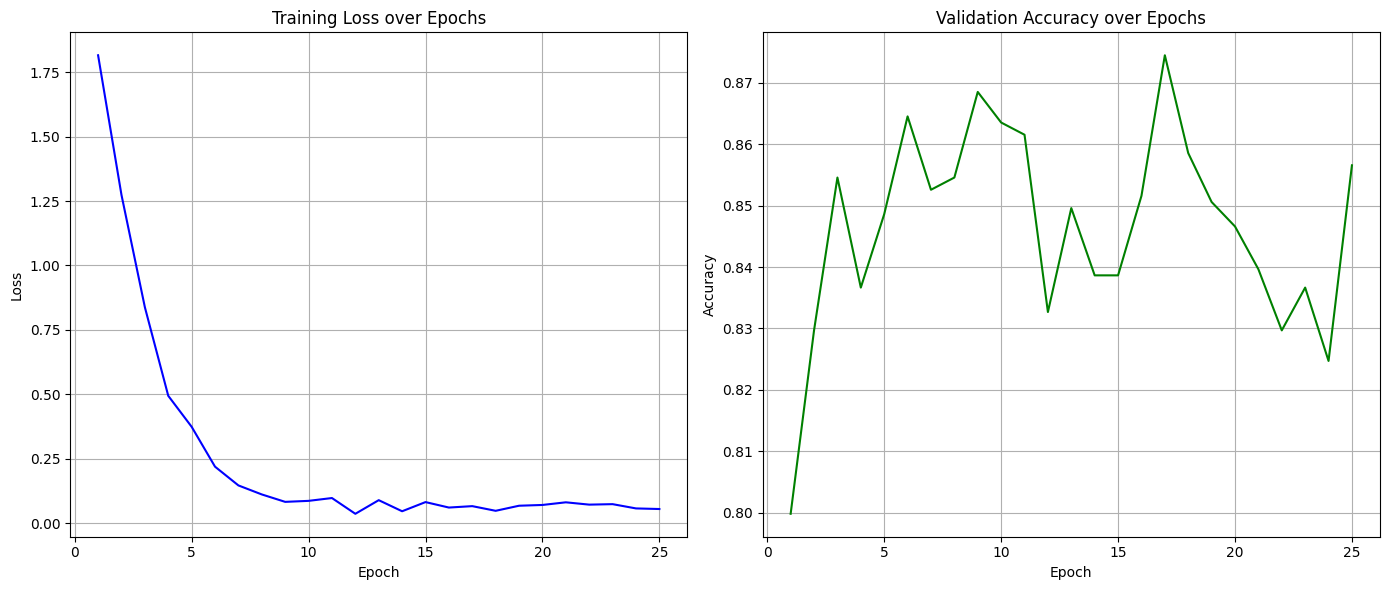

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Define AlexNet-based model with 4 custom heads
class MemorabilityModelWithAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MemorabilityModelWithAlexNet, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)

        in_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Identity()  # Remove final classification head

        # Custom heads for each memorability category
        self.iconic_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.contrast_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.symbolism_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.simplicity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.alexnet(x)
        return (
            self.iconic_head(features),
            self.contrast_head(features),
            self.symbolism_head(features),
            self.simplicity_head(features)
        )

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet_model = MemorabilityModelWithAlexNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            iconic, contrast, symbolism, simplicity = alexnet_model(images)

            # Compute losses
            loss1 = criterion(iconic.view(-1), labels[:, 0])
            loss2 = criterion(contrast.view(-1), labels[:, 1])
            loss3 = criterion(symbolism.view(-1), labels[:, 2])
            loss4 = criterion(simplicity.view(-1), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(iconic),
                torch.sigmoid(contrast),
                torch.sigmoid(symbolism),
                torch.sigmoid(simplicity)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader):.4f}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    alexnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            iconic, contrast, symbolism, simplicity = alexnet_model(images)

            pred1 = torch.sigmoid(iconic)
            pred2 = torch.sigmoid(contrast)
            pred3 = torch.sigmoid(symbolism)
            pred4 = torch.sigmoid(simplicity)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


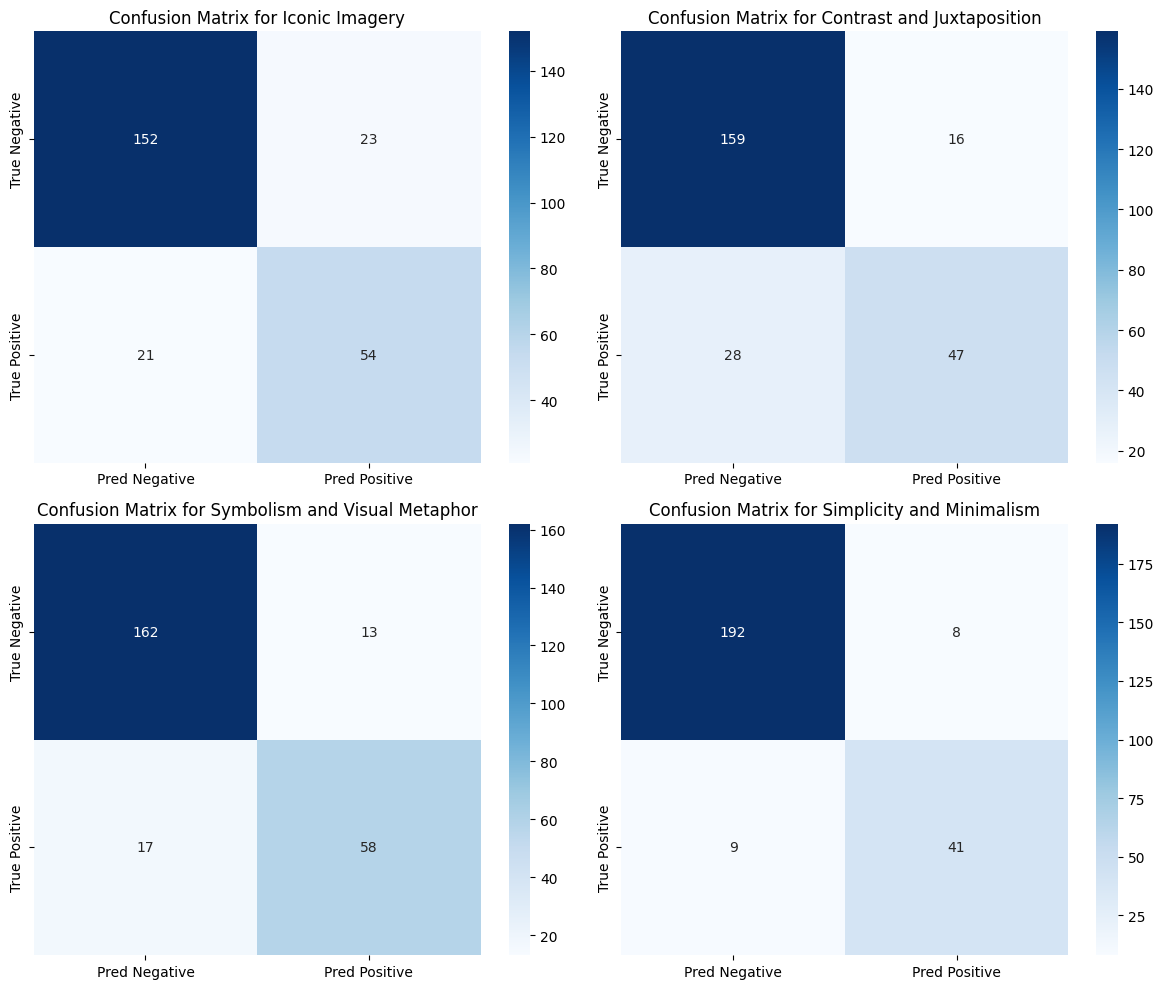

Test Accuracy: 86.50%
Precision: 73.60%
Recall: 73.00%
F1-Score: 72.93%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define memorability categories
memorability_categories = [
    "Iconic Imagery",
    "Contrast and Juxtaposition",
    "Symbolism and Visual Metaphor",
    "Simplicity and Minimalism"
]

# Set the model to evaluation mode
alexnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        iconic, contrast, symbolism, simplicity = alexnet_model(images)

        # Convert logits to probabilities using sigmoid
        pred_iconic = torch.sigmoid(iconic)
        pred_contrast = torch.sigmoid(contrast)
        pred_symbolism = torch.sigmoid(symbolism)
        pred_simplicity = torch.sigmoid(simplicity)

        # Binarize predictions (thresholding at 0.5)
        bin_iconic = (pred_iconic > 0.5).float()
        bin_contrast = (pred_contrast > 0.5).float()
        bin_symbolism = (pred_symbolism > 0.5).float()
        bin_simplicity = (pred_simplicity > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_iconic, bin_contrast, bin_symbolism, bin_simplicity], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {memorability_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
